In [ ]:
from analysis_utils import image2stack
from in_out import crop_save
from glob import glob
from tifffile import imwrite
from tqdm import tqdm
from visualization import show_one_image

import matplotlib.pyplot as plt
import numpy as np
import os
import tifffile as tiff
import PIL

In [2]:
# root_path = '/home/wrx/Data_WF/WF_WRX/'
root_path = '/home/wrx/Data_DOM/Widefield'

mouse_id = 'X1'
date = '20250318'
treatment = 'DOM'

treatment_folder = os.path.join(root_path, mouse_id, date, treatment)
print(treatment_folder)

/home/wrx/Data_DOM/Widefield/X1/20250318/DOM


In [ ]:
# Reading the images
chan1_folder_ls = glob(os.path.join(treatment_folder, '*-470'))
chan2_folder_ls = glob(os.path.join(treatment_folder, '*-405'))
print(chan1_folder_ls)
print(chan2_folder_ls)

Crop parameter setting

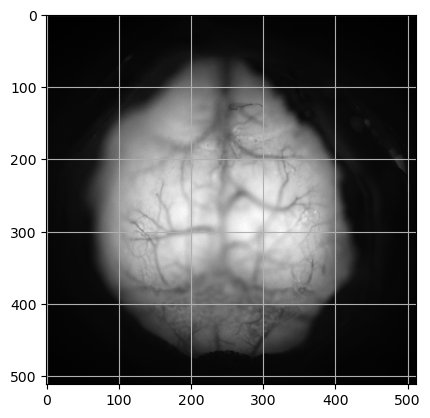

In [5]:
ref_image_path = os.path.join(chan1_folder_ls[0], '1.tif')
ref_image = plt.imread(ref_image_path)
show_one_image(ref_image)

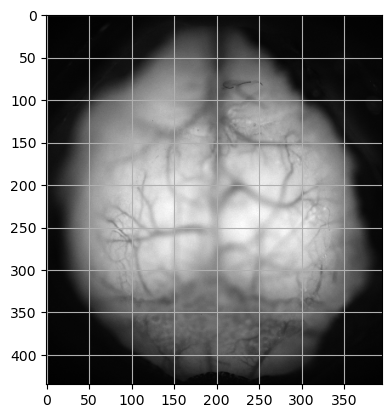

In [6]:
top, left, bottom, right = 45, 45, 480, 440
ref_image_crop = ref_image[top:bottom, left:right]
show_one_image(ref_image_crop)


In [7]:
im = PIL.Image.fromarray(ref_image_crop)
# do not save as tif, will error at TiffStack.export_binary otherwize
im.save(os.path.join(treatment_folder, 'reference.png'))

Save the parameter

In [8]:
parameters_path = os.path.join(treatment_folder, 'parameters.npy')
if os.path.exists(parameters_path):
    print('The parameters file exists')
    parameters = np.load(parameters_path, allow_pickle=True).item()
else:
    print('The parameters file does not exist')
    parameters = {}

parameters['crop'] = (top, left, bottom, right)
np.save(parameters_path, parameters)

The parameters file exists


Save the corpped image as tiff file

In [9]:
n_preview = 1000

In [21]:
def crop_save(folder, parameters, save_folder=None, n_preview=None, **kwargs):
    '''
    folder: the folder containing the images to crop images and save as tiff,
    there may be more than one folder for each channel
    parameters: the cropping parameters, tuples
    save_folder: the folder to save the cropped images
    '''
    from wf_utils import filename2int
    chan1_folder_ls = glob(os.path.join(folder, '*-470'))
    chan2_folder_ls = glob(os.path.join(folder, '*-405'))

    top, left, bottom, right = parameters

    chan1_image_ls = []
    for sub_folder in chan1_folder_ls:
        image_ls = glob(os.path.join(sub_folder, '*.tif'))
        # to make sure the images are in the right order
        image_ls = sorted(image_ls, key=filename2int)
        chan1_image_ls.extend(image_ls)
    chan2_image_ls = []
    for sub_folder in chan2_folder_ls:
        image_ls = glob(os.path.join(sub_folder, '*.tif'))
        image_ls = sorted(image_ls, key=filename2int)
        chan2_image_ls.extend(image_ls)
    # print(len(chan1_image_ls), len(chan2_image_ls))

    n_frames = np.min([len(chan1_image_ls), len(chan2_image_ls)])
    print(n_frames)
    
    if save_folder is None:
        if n_preview is None:
            tiff_path = os.path.join(folder, 'merged.tif')
        else:
            tiff_path = os.path.join(folder, 'preview.tif')
    n_write = n_frames if n_preview is None else n_preview
    with tiff.TiffWriter(tiff_path, bigtiff=True, imagej=True) as tif:
        for i in tqdm(range(n_write)):
            image1 = tiff.imread(chan1_image_ls[i])
            image2 = tiff.imread(chan2_image_ls[i])
            image1_cropped = image1[top:bottom, left:right]
            image2_cropped = image2[top:bottom, left:right]
            _merge = np.stack([image1_cropped, image2_cropped],
                axis=0).astype(np.uint16)
            tif.write(_merge, contiguous=True)

In [23]:
crop_save(treatment_folder, parameters=(top, left, bottom, right),
    n_preview=None)

/home/wrx/.conda/envs/wfield/lib/python3.11/site-packages/tifffile/tifffile.py:1569: UserWarning: <tifffile.TiffWriter 'merged.tif'> writing nonconformant BigTIFF ImageJ
  warnings.warn(


72000


100%|██████████| 72000/72000 [10:21<00:00, 115.81it/s]
